## Tensor - Lite

Welcome, to tensorlite . This project is made to make tensorflow simple. Here , we will be discussing about the different aspects of tensorflow. This project can be considered as a subset of tensorflow , to help everyone understand tensorflow and its concepts . 

We have some basic concepts in Tensorflow. 

1) Tensors - N-Dimentional Array, much like the ndArray of numpy

2) Operation - Any operation that is to be performed i.e. addition , multiplication, matrix-mltiplication

3) Graph - A global variable , which connects all these variables and placeholders in to a specific operation.

4) Variables - A variable or a changeble parameter of a graph. For example, weights of a neural network.

5) Placeholders - a placeholder for any unknown value. It can be also thought of as an empty node , which needs a value to compute output.

so, lets start by making a graph.

In [1]:
import numpy as np

In [2]:
class Graph():
    
    def __init__(self):
        
        self.operations = []
        self.placeholders = []
        self.variables = []
        
    def set_as_default(self):
        global _default_graph
        _default_graph = self

What we did, here , is that we constructed a graph class , which is nothing but a global variable which will connect all the variables , placeholders and operations together. Also, since we will be having multiple graphs , we will need to know , which operations and variables belong to which graph. Thus, we made a method named set_as_default, which makes a *_default_graph* global variable, and sets it to the reference of the graph.

for example,
if 

y = Mx + C ( which is standard equation of a straight line ) , we can classify this.

M = Variable & C = Variable
x = Placeholder

M(x) = Multiplication of M with x = Multiplication Operation
M(x) + c = Addition of M(x) with C = Addition Operation

now , why are M and C called variables , is because , these are the values that are being calculated. For example, in a simple regression problem, __y__ is the dependent variable which we have to predict. __x__ is the indepent variable or features, based on which the values of __y__ will be predicted. This is why __x__ is a placeholder since , we will feed the equation with __x__ to give the result. But , since M and C are to be calculated i.e. slope and intercept every time the the equation has to give a result, we define them as a variable.

In the case of a neural network, the weights of a neural network are the variables since , after each iteration the weight changes .

Now, all these things happen differently , thus we need some sort of a pipeline to connect all these things into one equation , thus we need a graph.

In [3]:
class Placeholder():
    
    def __init__(self):
        
        self.output_nodes = []
        
        #append the instance of the placeholder, to a global variable (graph) to be later get connected to a final operation
        _default_graph.placeholders.append(self)

In [4]:
class Variable():
    
    def __init__(self, initial_values=None): # we are having some initial values, such as random weights for a neural network
        
        self.values = initial_values
        self.output_nodes = []
        
        #append the instance of the Variable, to a global variable (graph) to be later get connected to a final operation
        _default_graph.variables.append(self)

---

Now comes the operation class , which is nothing but basic simple mathematical operations. Basically , an operation is based on 4 things - 

1) Input Nodes - The inputs passed onto the operation

2) Output Nodes - The ouput of the operation

3) Graph - A global variable , since it will be connecting the operations to other aspects of the equation (Placeholders and Variables)

4) Compute Method - Whihc will actually perform the mathematical calculation

In [5]:
class Operation():
    
    def __init__(self, input_nodes = []):
        
        self.input_nodes = input_nodes
        self.output_nodes = []
        
        for node in input_nodes:
            # for each node in input node, assign itself to the correct output node.
            node.output_nodes.append(self) 
                      
    def compute(self):
        pass

In [6]:
class add(Operation):
    
    def __init__(self, x, y):
        # we initialize the Main Operation class by the calling the Operation method and then by passing the list of input nodes
        # x and y
        super().__init__([x,y])
        
    def compute(self, x_variable, y_variable):
        self.inputs = [x_variable, y_variable]
        
        return x_variable + y_variable

In [7]:
class multiply(Operation):
    
    def __init__(self, x, y):
        # we initialize the Main Operation class by the calling the Operation method and then by passing the list of input nodes
        # x and y
        super().__init__([x,y])
        
    def compute(self, x_variable, y_variable):
        self.inputs = [x_variable, y_variable]
        
        return x_variable * y_variable

In [8]:
class matmul(Operation):
    
    def __init__(self, x, y):
        # we initialize the Main Operation class by the calling the Operation method and then by passing the list of input nodes
        # x and y
        super().__init__([x,y])
        
    def compute(self, x_variable, y_variable):
        self.inputs = [x_variable, y_variable]
        
        return x_variable.dot(y_variable)

Now for the equation , we know which element corresponds to what in our version of tensorflow, so what we can do is try to write the equation , based on what we kwow.So,

y = M(x) + C

=> let us assume M = 10 and C = 4

=> y = 10x + 4 , where 10 & 4 are variables and __x__ is a placeholder.


In [9]:
g = Graph()

In [10]:
g.set_as_default()
# we make this graph default for this particular set of operations.

In [11]:
M = Variable(10)
C = Variable(4)

In [12]:
x = Placeholder()

In [13]:
z = multiply(M, x)

In [14]:
y = add(z, C)

In [15]:
y

In [16]:
print(y)

As you can see nothing happened , even though we in the class method , we reutrned the sum of the two input variables , this is becuase , we havent feeded any data into the placeholder. Also, we need to have a __session__ class , which can be thought of as the main environment, local to which everythig works, even the graph, because , a graph is a global variable in context to a session.

Now for a session , we first need to have a function, to make sure that , we execute the computations in the correct order to maintain the legacy of the equation. For example in our equation ( y = mx + c ), we need to first multiply the m with x and then add c , otherwise , the equation will not produce the expected result.

So, we are going to tackle the problem using the PostOrder Tree Traversel method. It is a core computer science concept , about which you can read here https://www.geeksforgeeks.org/tree-traversals-inorder-preorder-and-postorder/

In [17]:
def traverse_postorder(operation):
    ## operation argument is the argument for the function, and not the Operation
    ## class . Just to be clear.
    
    nodes_postorder = []
    def recurse(node):
        if isinstance(node, Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append(node)
        
    recurse(operation)
    return nodes_postorder

So we have made a recursive function, which basically first checks , that the current operation is an instance of the main __Operation__ class. If that is the case, we will use use the recursive function strategy , to execute the operations in correct order. It will form a list of operations , in order they need to be executed.

Now , we will make a session class, which will actually set the environment to execute the the equation.

In [18]:
class Session():
    
    def run(self, operation, feed_dict={}):
        
        nodes_postorder = traverse_postorder(operation)
        
        for node in nodes_postorder:
            
            if type(node) == Placeholder:
                
                node.output = feed_dict[node]
                
            elif type(node) == Variable:
                
                node.output = node.values
                
            else:
                
                #Operations
                node.inputs = [input_node.output for input_node in node.input_nodes]
                
                node.output = node.compute(*node.inputs)
                
            if type(node.output) == list:
                node.output = np.array(node.output)
                
        return operation.output

So, we created a session class, and as evident it is just setting up the context for execution of the equation. First it corrects the order of the equation. Then, for each node in the sorted list , we check the type of each node , and perform respective operation to it.

so starting out , where we left off . 

we made the operation for __y__, now we will calculate the final value.

In [19]:
sess = Session()

In [20]:
result = sess.run(operation = y, feed_dict={x:10})

In [21]:
result

104

Now this makes sense. Since the equation was __y = mx + c__, where, M and C were , 10 and 4 respectively. Now we passed on x = 10 , in the feed_dict argument above. Thus , the equation will correspond to , __y = 10x(10) + 4__, which is __104__

Since, we pass in many batches of data or features to the placeholder in the real world, we need to use a dictionary , which will map each placeholder to a value. 

In [22]:
## lets make a complete equation. 
g = Graph()
g.set_as_default()
## we'll use the same equation, but this time with a matrix
# Y = Ax + B

A = Variable([[1,2], [3,4]])
B = Variable([1,2])

x = Placeholder()

z = matmul(A, x)

Y = add(z, B)

sess = Session()


In [23]:
result = sess.run(operation = Y, feed_dict = {x:10})

In [24]:
result

array([[11, 22],
       [31, 42]])

---

## Classification using a simple feedforward neural network

We start by making an activation function. If you have used any deep learning library, you might know about activation function. Basically it is just a function, which operates on the data to classify the data into either 0 or 1, i.e. classify things. Here , we are using sigmoid function, which is nothing but the formula down below. You can also use the __reLU__ activation function , which is __max(0,x)__ .

In [26]:
class sigmoid(Operation):
    
    def __init__(self, z):
        super().__init__([z])
        
    def compute(self, z_val):
        return 1 / (1 + np.exp(-z_val))

let make a fake dataset and plot it.

In [27]:
from sklearn.datasets import make_blobs

In [43]:
data = make_blobs(n_samples = 50, n_features = 2, centers = 2, random_state = 75)

In [44]:
data

(array([[  7.3402781 ,   9.36149154],
        [  9.13332743,   8.74906102],
        [  1.99243535,  -8.85885722],
        [  7.38443759,   7.72520389],
        [  7.97613887,   8.80878209],
        [  7.76974352,   9.50899462],
        [  8.3186688 ,  10.1026025 ],
        [  8.79588546,   7.28046702],
        [  9.81270381,   9.46968531],
        [  1.57961049,  -8.17089971],
        [  0.06441546,  -9.04982817],
        [  7.2075117 ,   7.04533624],
        [  9.10704928,   9.0272212 ],
        [  1.82921897,  -9.86956281],
        [  7.85036314,   7.986659  ],
        [  3.04605603,  -7.50486114],
        [  1.85582689,  -6.74473432],
        [  2.88603902,  -8.85261704],
        [ -1.20046211,  -9.55928542],
        [  2.00890845,  -9.78471782],
        [  7.68945113,   9.01706723],
        [  6.42356167,   8.33356412],
        [  8.15467319,   7.87489634],
        [  1.92000795,  -7.50953708],
        [  1.90073973,  -7.24386675],
        [  7.7605855 ,   7.05124418],
        [  6

In [50]:
import pandas as pd

In [54]:
df = pd.DataFrame({
    'Features1': data[0][:,0],
    'Features2': data[0][:,1],
    'Lables': data[1]
})
df.head()

,Features1,Features2,Lables
0,7.340278,9.361492,1
1,9.133327,8.749061,1
2,1.992435,-8.858857,0
3,7.384438,7.725204,1
4,7.976139,8.808782,1


In [55]:
features = data[0]
lables = data[1]

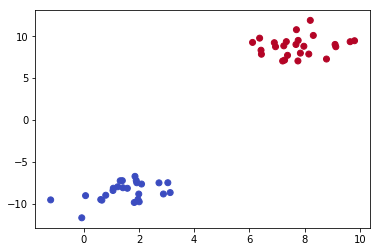

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(features[:,0], features[:,1], cmap='coolwarm', c=lables)

Now lets classify the items. Since we have a fairly simple dataset, we dont need to apply heavy mathematical calculations to it.
We can just classify the items based on a simple line. Lets use our standard straight line equation __y = m(x) + c__. 

We'll use, y = -x + 4 lets say

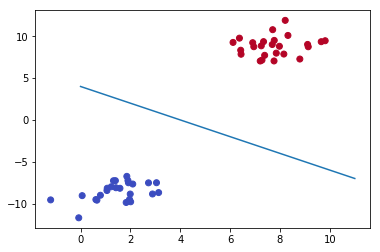

In [59]:
x = np.linspace(0,11,10)
y = -x + 4
plt.scatter(features[:,0], features[:,1], cmap='coolwarm', c=lables)
plt.plot(x,y)

Here , we see that this fits quite well to the graph. If you are wondering , why __-x__, this is because , a negative slope (m), produces this type of downward line, otherwise positive slope , produces upward slanting line. So any value above this line or with a value close to 1 belongs to red class and below the line or with the value close to 0 belongs to blue class.

In [60]:
g = Graph()
g.set_as_default()

In [70]:
## Equation is y = -x + c
x = Placeholder()
c = Variable(-4)
m = Variable([1,1])
y = add(matmul(m,x), c)

In [71]:
a = sigmoid(y)

In [72]:
sess = Session()

In [73]:
sess.run(operation = a, feed_dict={x:[10,11]})

0.9999999586006244

So this number since it is close to 1 , it belongs to red class.

---

This brings us to the end of the library. This library for now , is able to do basic classification and regression and is also able to make a simple feedforward neural network. The project is planned to extend further, if it gets a good response.